<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Recommendations: Collaborative Filtering Lab

_Author: Dan Wilhelm (LA)_

---

# Collaborative Filtering Lab

Today, we will be writing User-based and Item-based Collaborative Filtering recommendation engines. First, we'll write a User-based engine. This ranks each user by similarity to a given user. Then, it recommends brands from the most similar users, weighting each brand by the users' similarity.

Because Collaborative Filtering is relatively easy to implement and not part of Scikit-learn, we will be writing it from scratch using vanilla Python.

In [1]:
from collections import Counter

from matplotlib import pyplot as plt

%matplotlib inline

BRANDS_FILE = '../../datasets/user_brand.csv'

## Load in User-Brands Data

In [2]:
user_brands = dict()

with open(BRANDS_FILE, 'r', encoding='utf-8') as fin:
    data = [tuple(line.strip().split(",")) for line in fin]

data[:20]

[('80002', 'Target'),
 ('80002', 'Home Depot'),
 ('80010', "Levi's"),
 ('80010', 'Puma'),
 ('80010', 'Cuisinart'),
 ('80010', 'Converse'),
 ('80010', 'DKNY'),
 ('80010', 'Express'),
 ('80010', "Kohl's"),
 ('80010', 'Old Navy'),
 ('80010', 'Container Store'),
 ('80010', 'Nordstrom'),
 ('80011', 'Kenneth Cole'),
 ('80011', 'Calvin Klein'),
 ('80011', 'French Connection'),
 ('80011', 'BCBGMAXAZRIA'),
 ('80011', 'Nine West'),
 ('80011', 'Steve Madden'),
 ('80011', 'Diesel'),
 ('80011', 'Guess')]

## Explore the Data

To assist you in exploring, make the following variables:

In [3]:
users = [line[0] for line in data]   # List of all users
brands = [line[1] for line in data]  # List of all brands

# user_brands = {'48132': {'Target', 'H&M', 'Gap'}, '31341': {'Zipcar'}, ... }
user_brands = {}
for user, brand in data:
    # If key 'user' hasn't been added yet, set it to an empty set with set(), then add the brand to the set
    user_brands.setdefault(user, set()).add(brand)

# brand_users = {'Target': {'48132', '84172', '12353'}, 'Zipcar': {'31341'}, ... }
brand_users = {}
for user, brand in data:
    # Likewise for each brand (aggregate a set of users)
    brand_users.setdefault(brand, set()).add(user)

1 - How many unique users are there?

In [4]:
len(set(users))

3759

2 - How many unique brands are there?

In [5]:
len(set(brands))

198

3 - What is the distribution of the number of brands liked by users?

_Hint:_ Make a list of ```likes_per_brand``` then plot a histogram! 

+ For example: ```plt.hist([1, 1, 1, 2, 2, 3], bins=3)```

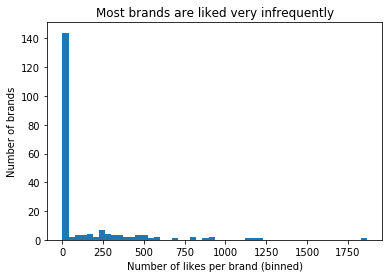

In [6]:
# list of number of brand likes
likes_per_brand = [len(brand_users[key]) for key in brand_users.keys()]
    
plt.hist(likes_per_brand, bins=50);
plt.xlabel('Number of likes per brand (binned)');
plt.ylabel('Number of brands');
plt.title('Most brands are liked very infrequently');

4 - What is the distribution of the number of users who like a brand?

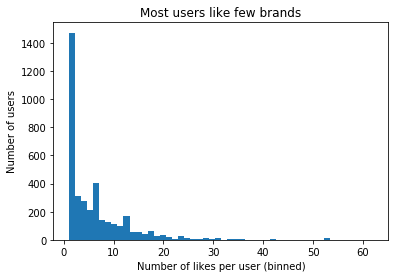

In [7]:
# list of number of brand likes
likes_per_user = [len(user_brands[key]) for key in user_brands.keys()]

plt.hist(likes_per_user, bins=50);
plt.xlabel('Number of likes per user (binned)');
plt.ylabel('Number of users');
plt.title('Most users like few brands');

5 - How many people like **Target**?

In [8]:
brands.count('Target')

1866

6 - How many people like **Banana Republic**?

In [9]:
brands.count('Banana Republic')

932

7 - What brands does **user 86184** like?

In [10]:
user_brands['86184']

{'DKNY', 'Express', 'Guess', "Kohl's", 'Old Navy', 'Target'}

8 - What brands does **user 83126** like?

In [11]:
user_brands['83126']

{'CB2', 'Container Store', 'Restoration Hardware', 'Serena and Lily'}

## Jaccard Distance Measure

Given two sets of brands, e.g. `user1 = {'Target', 'Starbucks', 'Gap'} and user2 = {'Starbucks', 'Old Navy'}`, the Jaccard distance is:

+ jaccard(u1, u2) = 1 - (# brands in common) / (# brands in total).

In [12]:
def jaccard_distance(set1, set2):
    if not set1 and not set2:
        return 0.0
    
    return 1. - (len(set1 & set2) / len(set1 | set2))

In [13]:
# Make test sets by hand, for example using 'Target' and 'Banana Republic'.
# Compute what the jaccard distance should be for your test set.
# Does calling your function yield the same result?

assert(jaccard_distance({'Target'}, {'Target'}) == 0.0)
assert(jaccard_distance({'Target'}, {'Target', 'Banana Republic'}) == 0.5)
assert(jaccard_distance({'Gap'}, {'Target', 'Banana Republic'}) == 1.0)
assert(jaccard_distance({'Gap'}, set()) == 1.0)

## Weighted Jaccard Distance

This metric does not fully capture our intution of distance between two users and the brands they like. For example, two users who have Target in common are less likely to be similar than users who have Autozone in common. So, let's add a weighting which emphasizes less frequent brands.

+ Weight each brand by 1/(brand's total likes). This is a useful measure, since we want a large weight with only 2 likes and a much smaller weight with 100 likes.
+ This weighting works because "Target" is liked by most users, so it is a less meaningful brand for similarity than "Zipcar".

In [14]:
# count how many times each brand appears in the entire dataset
brand_freq = Counter([line[1] for line in data])

def weighted_jaccard_distance(set1, set2):
    if not set1 and not set2:
        return 0
    
    weighted_intersection = (1. / brand_freq.get(brand) for brand in set1 & set2)
    weighted_union = (1. / brand_freq.get(brand) for brand in set1 | set2)
    
    return 1. - (sum(weighted_intersection) / sum(weighted_union))

In [15]:
# Make test sets by hand, for example using 'Target' and 'Banana Republic'.
# Compute what the weighted jaccard score should be for your test set.
# Does calling your function yield the same result?

# Computing an example by hand
print(brand_freq.get('Target'), brand_freq.get('Banana Republic'))
print(1. - (1./1866) / (1./1866 + 1./932))

# Testing
weighted_jaccard_distance({'Target'}, {'Target', 'Banana Republic'})

1866 932
0.6669049320943531


0.6669049320943531

## Recommendation Engine

First, we'll define two already completed helper functions. 

```
# Pretty-prints similar brands to Target
for_brands('Target')

# Pretty-prints brands that user 86184 will like
for_users('86184') 
```



In [16]:
def for_brands(brand_name):
    """
    Given a brand name **string**, returns a pretty-print string of 
      recommendations of more brands.
    """

    # IMPORTANT: 'recommend_for_brands' expects a set of brand names.
    #   So, because 'brand_name' is a string, we convert the single name 
    #   to a set containing the brand name

    recs = recommend_for_brands(set([brand_name]))

    return "For a user who likes {liked}, we recommend {recs}.".format(
        liked=brand_name,
        recs=", ".join(recs))


def for_user(user):
    """
    Given a user name **string**, returns a pretty-print string 
      of recommendations for a user.
    """
    recs = recommend_for_user(user)

    return "For user {user}, who likes {liked}, we recommend {recs}.".format(
        user=user,
        liked=", ".join(user_brands.get(user, ["nothing"])),
        recs=", ".join(recs))

Next, we define how to recommend brands to users. Make sure you understand how it works -- we just ask for similar brands to the brands the user already likes. The below function is complete!

In [17]:
def recommend_for_user(user_string):
    """
     Recommend items to a user that are similar 
       to the brands the user already likes
    """

    return recommend_for_brands(user_brands.get(user_string, set()))

    # NOTE: The second parameter to get() is the default
    #   value to send if the user is not a key in 'user_brands'

Finally, we implement recommending brands based on a list of brands. To do this, we will find the users closest to the brands set. Then, other brands that those users like will be recommended. 

Use the ```jaccard``` or ```jaccard_weighted``` as your distance function to rank users. Then, use your best judgement for how to collect the additional brands.

In [18]:
def recommend_for_brands(brands_set):
    """
    Return top five recommended brands
      based on the brands in 'brands_set'.
    """
    
    # The strategy is:
    #   (1) Find the users most similar to the 'brands_set'.
    #   (2) Get 5 brands those users also like
    #   (3) OPTIONAL: Weight the 5 stores by most unique to least unique

    # user_brands.items() = [('48132', {'Target', 'H&M', 'Gap'}), ('31341', {'Zipcar'}), ... }
    #  + 'sorted' sorts a tuple normally by its first element.
    #  + 'key' is a number used to sort the items. 'x' stands for the current item
    #     being sorted, so it is the set of brands for the current user (see the line above).
    #  + We do not reverse the sorted list, since we want the smallest distance first.
    user_brands_by_distance = sorted(user_brands.items(),
                                     key=lambda x: weighted_jaccard_distance(brands_set, x[1]),
                                     reverse=False)
    
    # At this point, the user/brands dictionary is sorted by similarity to the 'brands_set'
    # For example:
    # + For brand_set = {'Old Navy', 'DKNY', 'Guess', 'Express', 'Target', "Kohl's"}, then:
    # + user_brands_by_distance[:5] = [
    #    ('86184', {'Old Navy', 'DKNY', 'Guess', 'Express', 'Target', "Kohl's"}), 
    #    ('90464', {'DKNY', 'Guess', 'Express', 'Target', "Kohl's"}), 
    #    ('82877', {'DKNY', 'Guess', 'Express'}), 
    #    ('90920', {'Old Navy', 'DKNY', 'Crate & Barrel', 'Guess', 'Express', 'Home Depot', 'BCBGMAXAZRIA', "Kohl's"}), 
    #    ('81511', {'Lacoste', 'Old Navy', 'DKNY', 'Banana Republic', 'Guess', 'Express'})]
    
    # Slow but easy to read
    ordered_brands = []
    for user,brands in user_brands_by_distance:
        ordered_brands += [brand for brand in brands \
                           if brand not in brands_set and brand not in ordered_brands]
    
    # sorted() is only to complete the OPTIONAL challenge
    # - Sorted by most unique (largest 1/freq) to least unique (smallest 1/freq)
    #   Otherwise, could just return ordered_brands[:5]
    return sorted(ordered_brands[:5], 
                  key=lambda x: 1. / brand_freq[x], 
                  reverse=True)

## Testing

In [19]:
# For testing, recommend brands similar to Target and Banana Republic
print("\n" + for_brands("Target") + "\n")
print(for_brands("Banana Republic") + "\n")

# For testing, recommend brands for users 86184 and 83126
#    NOTE: This is based on the brands each user likes
print(for_user("86184") + "\n")
print(for_user("83126") + "\n")


For a user who likes Target, we recommend Nordstrom, Banana Republic, Kohl's, Home Depot, Old Navy.

For a user who likes Banana Republic, we recommend Nordstrom, Kohl's, Home Depot, Old Navy, Target.

For user 86184, who likes Kohl's, DKNY, Old Navy, Guess, Express, Target, we recommend Lacoste, BCBGMAXAZRIA, Crate & Barrel, Banana Republic, Home Depot.

For user 83126, who likes Container Store, Restoration Hardware, CB2, Serena and Lily, we recommend Le Creuset, 6pm.com, Crocs, Crate & Barrel, Nordstrom.



## Next Step: Item-based Collaborative Filtering

You just did user-based collaborative filtering:
+ Step one: Find users similar to the target user (or set of brands)
+ Step two: Recommend things that similar users like.
    
Consider now framing the problem as an item-based problem:
+ Step one: Determine similarity of brands to one another (via users)
+ Step two: Recommend things that are similar to what the target user likes.

In [20]:
def recommend_for_brand(brand_name, excluded_brands={}, nrecs=1):
    """Return at most `nrecs` ordered recommended brands
    for the brand given by `brand_name`. If specified, 
    all brands in `excluded_brands` are not recommended.
    """
    
    # If no users liked the brand, return no recommendations
    if brand_name not in brand_users:
        return []
    
    # List of brands liked ALONGSIDE `brand_name`
    # Filters out brands in `excluded_brands`
    users = brand_users[brand_name]
    other_brands_liked = [brand for user in users \
                                for brand in user_brands[user] \
                                if brand not in excluded_brands]
    
    # Return the `nrecs` most common brands liked
    other_brand_counts = Counter(other_brands_liked)
    
    return [brand for brand,count in other_brand_counts.most_common(nrecs)]
    

def recommend_for_brands(brands_set):
    """Return the top recommended brand for
        each brand in `brands_set` using
        Item-based collaborative filtering.
    """
    recommended_brands = []
    
    # Combine recommendations for each brand
    for brand_name in brands_set:
        recommended_brands.extend(
            recommend_for_brand(brand_name, 
                                excluded_brands=brands_set,
                                nrecs=1))
    
    return set(recommended_brands)

In [21]:
# For testing, recommend brands similar to Target and Banana Republic
print("\n" + for_brands("Target") + "\n")
print(for_brands("Banana Republic") + "\n")

# For testing, recommend brands for users 86184 and 83126
#    NOTE: This is based on the brands each user likes
print(for_user("86184") + "\n")
print(for_user("83126") + "\n")


For a user who likes Target, we recommend Old Navy.

For a user who likes Banana Republic, we recommend Target.

For user 86184, who likes Kohl's, DKNY, Old Navy, Guess, Express, Target, we recommend Banana Republic, Calvin Klein, Home Depot, Nordstrom.

For user 83126, who likes Container Store, Restoration Hardware, CB2, Serena and Lily, we recommend Crate & Barrel, Target.



## Challenge: Try a different dataset!

Get the Delicious bookmarks from [here](https://grouplens.org/datasets/hetrec-2011/). This dataset contains 105,000 bookmarks from 1867 users.

1. Given a user's set of links, recommend additional links the user might enjoy. Use User-based or Item-based filtering.

2. Calculate similarity between tags. Are any tags almost identical? Find some bookmarks that could have been tagged "programming" but were not.


In [22]:
# Solution not provided